### 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

os.chdir("../")
from scripts import utils
from pathlib import Path
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm

In [2]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import distclassipy as dcpy

In [4]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
seed_val = settings_dict["seed_choice"]
np.random.seed(seed_val)
sns_dict = settings_dict["sns_dict"]
sns.set_theme(**sns_dict)

In [5]:
settings_dict["all_metrics"]

['euclidean',
 'braycurtis',
 'canberra',
 'cityblock',
 'chebyshev',
 'clark',
 'correlation',
 'cosine',
 'hellinger',
 'jaccard',
 'lorentzian',
 'marylandbridge',
 'meehl',
 'motyka',
 'soergel',
 'wave_hedges',
 'kulczynski',
 'add_chisq']

In [6]:
# unique_metrics = [
#     "euclidean",
#     "braycurtis",
#     "canberra",
#     "cityblock",
#     "chebyshev",
#     "clark",
#     "correlation",
#     "cosine",
#     "hellinger",
#     "jaccard",
#     "lorentzian",
#     "marylandbridge",
#     "meehl",
#     "soergel",
#     "wave_hedges",
#     "kulczynski",
#     "add_chisq",
#     "acc",
#     "chebyshev_min",
#     "dice",
#     "divergence",
#     "google",
#     "jeffreys",
#     "kumarjohnson",
#     "penroseshape",
#     "squared_chisq",
#     "squaredchord",
#     "squared_euclidean",
#     "taneja",
#     "topsoe",
#     "vicis_symmetric_chisq",
#     "vicis_wave_hedges",
# ]

unique_metrics = ['euclidean',
 'braycurtis',
 'canberra',
 'cityblock',
 'chebyshev',
 'clark',
 'correlation',
 'cosine',
 'hellinger',
 'jaccard',
 'lorentzian',
 # 'marylandbridge',
 'meehl',
 'motyka',
 'soergel',
 'wave_hedges',
 'kulczynski',
 'add_chisq']


final_features = [
    "SPM_A_Y",
    "Multiband_period",
    "r-i",
    "Harmonics_phase_4_i",
    "Harmonics_phase_2_r",
    "Power_rate_4",
]

In [7]:
features = pd.read_parquet("data/reduced_balancedfeatures_LATEST.parquet")
features["class"].value_counts()

class
CEP     683
DSCT    683
EB      683
RRL     683
Name: count, dtype: int64

In [8]:
features = features.sample(frac=1)

In [9]:
y_normal_df = features["class"]
# X_df = features.drop(["Coordinate_x", "Coordinate_y", "Coordinate_z", "class"], axis=1)
X_normal_df = features.loc[:, final_features]

In [10]:
other_features_df = pd.read_parquet("data/otherclassobjs_features.parquet")
other_features_df.index.name = "snid"
other_lc_df = pd.read_parquet("data/otherclassobjs.parquet")
other_lc_df.index.name = "snid"

other_lc_df=other_lc_df[~other_lc_df["class"].isin(['d-Sct', 'Cepheid', 'EB', 'RRL'])]
other_features_df=other_features_df.loc[other_lc_df.index]


other_lc_df = other_lc_df.loc[other_features_df.index]

assert (other_lc_df.index == other_features_df.index).all()

In [11]:
X_anom_df = other_features_df.loc[:, X_normal_df.columns].dropna()
X_anom_df = X_anom_df.drop(np.intersect1d(X_anom_df.index, X_normal_df.index))
y_anom_df = other_lc_df.loc[X_anom_df.index]["class"]
X_anom_df=X_anom_df.loc[y_anom_df.index]

In [12]:
y_anom_df.unique()

array(['PISN-STELLA_HYDROGENIC', 'PISN-MOSFIT', 'uLens-Single_PyLIMA',
       'TDE', 'SNIcBL+HostXT_V19', 'KN_B19', 'uLens-Binary', 'SL-SNII',
       'SNIc-Templates', 'SLSN-I+host', 'SNIa-SALT3', 'SNIb-Templates',
       'SNII+HostXT_V19', 'SNIa-91bg', 'SL-SNIb', 'Mdwarf-flare', 'ILOT',
       'KN_K17', 'CART', 'SNIIb+HostXT_V19', 'SNIb+HostXT_V19', 'SL-SN1a',
       'SNII-NMF', 'SNIIn+HostXT_V19', 'SNII-Templates',
       'SNIc+HostXT_V19', 'SNIax', 'SNIIn-MOSFIT', 'uLens-Single-GenLens',
       'PISN-STELLA_HECORE', 'AGN', 'SLSN-I_no_host', 'SL-SNIc',
       'dwarf-nova'], dtype=object)

In [13]:
X_df = pd.concat([X_normal_df, X_anom_df])
y_df = pd.concat([y_normal_df, y_anom_df])

In [14]:
assert (X_df.index == y_df.index).all()

### 1. Isolation Forest

In [15]:
from sklearn.ensemble import IsolationForest
from scipy import stats

In [16]:
def runif(random_state, X_traindf, X_testdf):
    clf = IsolationForest(
        max_samples=10, contamination="auto", random_state=random_state
    )
    clf.fit(X_traindf)  # , sample_weight=1.0/(Xfixed[:,2,:])**2)
    scores_pred_Norm = clf.decision_function(X_testdf)
    # scores_pred_Norm = clf.score_samples(X)
    # .sample_score(X)

    threshold_Norm = stats.scoreatpercentile(scores_pred_Norm, 100 * 0.1)
    #y_predNorm = clf.predict(X)
    abornmality = -scores_pred_Norm
    iforest_df = pd.DataFrame(
        abornmality, columns=["abnormality"], index=X_testdf.index,
    )  # higher is more abnormal
    # iforest_df.index.name = "sample_num"
    iforest_df = iforest_df.sort_values(by="abnormality", ascending=False)
    return iforest_df.index, iforest_df

In [17]:
ranksIF = []
ranksIDdfs = []
ifseeds = np.random.randint(100, 1000, 3)
for i in ifseeds:
    _ = runif(i, X_traindf=X_normal_df, X_testdf=X_df)
    ranksIF.append(_[0])
    ranksIDdfs.append(_[1])
ranksIF

[Index([ 96837672,  94602724,  88253880, 125103424,  92717442, 130307557,
         34882116,  37691298,   4183976,  34160718,
        ...
         22271523,  47340254,  25574309,  46522535,  55461733,  54311883,
         51885084,  53909322,  59909628,  70781811],
       dtype='int64', name='snid', length=4318),
 Index([ 96837672,  34882116,  94602724,  92717442, 125103424,  83406315,
        132356710,  59245585, 108559610, 101561282,
        ...
         12266070,  41220232,  77317116, 100486651,  64901941,  25574309,
         53358169,   1283805,  10552144,  13873224],
       dtype='int64', name='snid', length=4318),
 Index([ 96837672,  94602724,  34882116, 108559610,  92717442,  34160718,
         63030733, 130307557,  59245585, 114522598,
        ...
         54711051, 124834816,  32015691,  25574309,  48122575,  49850945,
        156074442,  51885084, 143879284,  12266070],
       dtype='int64', name='snid', length=4318)]

/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_88613/2281571738.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(


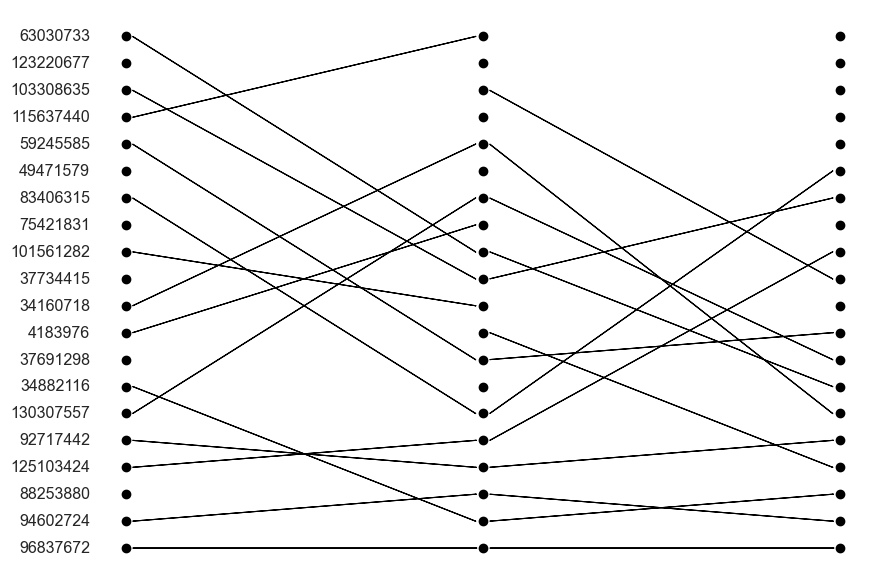

In [18]:
def plotstuff(list_a, list_b, i, ax, arrow_len=0.1):
    # Plot the two columns of equidistant points
    a = list(list_a)
    b = list(list_b)
    a_to_b_indices = [b.index(x) + 1 if x in b else None for x in a]
    for j, target_index in enumerate(a_to_b_indices):
        if target_index is not None:
            ax.arrow(
                0.02 + i,
                j + 1,
                0.96,
                target_index - (j + 1),
                # head_width=0.05 * arrow_len * 10, head_length=0.1 * arrow_len * 10,
                fc="black",
                ec="black",
                length_includes_head=False,
            )


def plot_ranks(rankslists, nsamples=10, labels_offset=0.1):
    """
    Plots two columns of points representing two lists (a and b)
    and draws arrows connecting the rank of elements in 'a' to
    their corresponding position in 'b'.

    Args:
        a (list): The first list of elements.
        b (list): The second list of elements.
        labels_offset (float, optional): Offset for the text labels. Defaults to 0.1.
        arrow_len (float, optional): Length of the arrows. Defaults to 0.1.
    """
    n_items = nsamples
    fig, ax = plt.subplots(
        figsize=(3 * len(rankslists), n_items * 0.3)
    )  # Adjust figure size

    for i in range(len(rankslists)):
        if i == 0:
            a = rankslists[i][:nsamples]
            ax.plot(
                np.ones(n_items),
                np.arange(1, n_items + 1),
                "o",
                markersize=6,
                color="black",
            )
            for j, val in enumerate(a):
                ax.text(1 - labels_offset, j + 1, str(val), ha="right", va="center")
        else:
            b = rankslists[i][:nsamples]
            a = rankslists[i - 1][:nsamples]
            ax.plot(
                np.full(n_items, i + 1),
                np.arange(1, n_items + 1),
                "ro",
                markersize=6,
                color="black",
            )
            for j, val in enumerate(b):
                if not val in b:
                    ax.text(
                        1 - labels_offset + i, j + 1, str(val), ha="right", va="center"
                    )
            plotstuff(a, b, i, ax)

        # Remove axes and labels
        # ax.set_xlim(0, 3)
    ax.set_ylim(0, n_items + 1)
    ax.axis("off")
    plt.tight_layout()

    plt.show()


plot_ranks(ranksIF, nsamples=20)

In [19]:
df=pd.concat(ranksIDdfs,axis=1)
df.columns = ["if1", "if2", "if3"]
for c in df.columns:
    df["quartile_" + c] = pd.qcut(df[c], q=4, labels=False)  # Divides into 4 quantiles
df

,if1,if2,if3,quartile_if1,quartile_if2,quartile_if3
snid,,,,,,
96837672,0.153602,0.155124,0.154811,3,3,3
94602724,0.151189,0.152706,0.151189,3,3,3
88253880,0.146843,0.119747,0.129081,3,3,3
125103424,0.144949,0.147896,0.131143,3,3,3
92717442,0.142569,0.149095,0.140373,3,3,3
...,...,...,...,...,...,...
54311883,-0.082787,-0.057494,-0.072321,0,0,0
51885084,-0.083877,-0.071587,-0.087401,0,0,0
53909322,-0.084936,-0.063280,-0.073858,0,0,0


In [20]:
df["class"] = y_df.loc[df.index]

In [21]:
df.iloc[:20]

,if1,if2,if3,quartile_if1,quartile_if2,quartile_if3,class
snid,,,,,,,
96837672,0.153602,0.155124,0.154811,3,3,3,CEP
94602724,0.151189,0.152706,0.151189,3,3,3,CEP
88253880,0.146843,0.119747,0.129081,3,3,3,SNIa-91bg
125103424,0.144949,0.147896,0.131143,3,3,3,CEP
92717442,0.142569,0.149095,0.140373,3,3,3,CEP
130307557,0.140443,0.133194,0.139015,3,3,3,CEP
34882116,0.140443,0.153602,0.150165,3,3,3,CEP
37691298,0.136690,0.102822,0.126905,3,3,3,SNII-Templates
4183976,0.136656,0.133437,0.126493,3,3,3,CEP


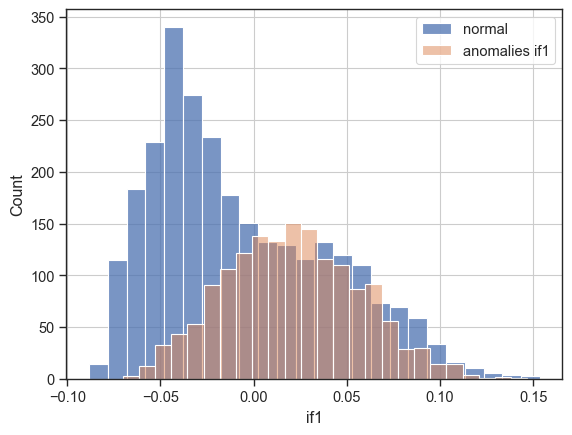

In [22]:
sns.histplot(df[df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)]["if1"], label="normal")

sns.histplot(df[~df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)]["if1"], label="anomalies if1", alpha=0.5)
    
plt.legend()
plt.show()

## SAME BINS

In [23]:
X_normal_df.to_csv("X_normal_df.to_csv", index=True)
X_df.to_csv("X_df.to_csv", index=True)

y_normal_df.to_csv("y_normal_df.to_csv", index=True)
y_df.to_csv("y_df.to_csv", index=True)

In [24]:
# Do TSNE here

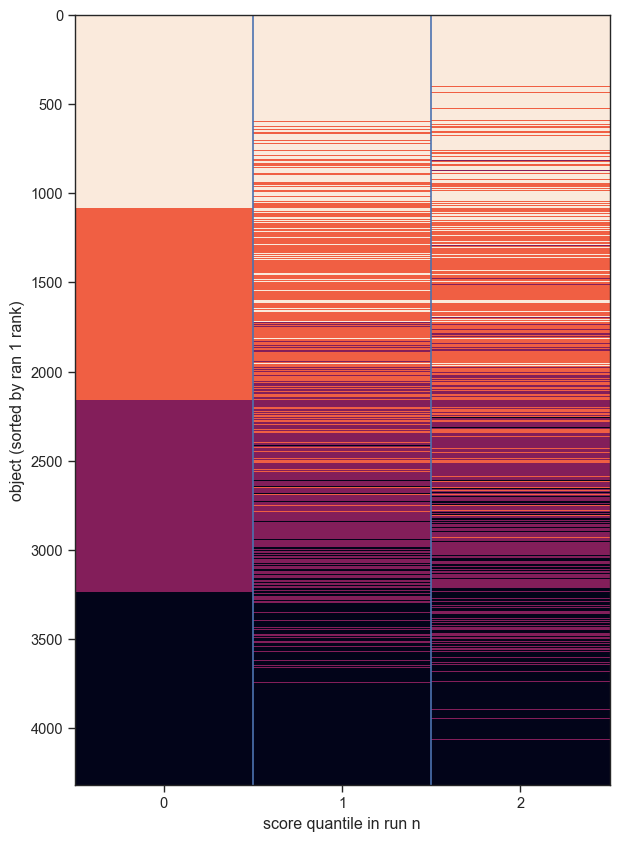

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(df[["quartile_if1", "quartile_if2", "quartile_if3"]], interpolation="none")
ax.set_aspect(0.001)
ax.set_xlabel("score quantile in run n")
ax.set_xticks(range(len(df.columns) - 3-1))
ax.set_ylabel("object (sorted by ran 1 rank)")
plt.grid(None)
ax.axvline(0.5)
ax.axvline(1.5)

In [26]:
top_quantile = df[df["quartile_if1"] == df["quartile_if1"].max()][["quartile_if1", "quartile_if2", "quartile_if3"]]
print(
    f'fraction of run2 top quantile in run 1 {(top_quantile["quartile_if1"] == top_quantile["quartile_if2"]).sum() / top_quantile.shape[0]}'
)
print(
    f'fraction of run3 top quantile in run 1 {(top_quantile["quartile_if1"] == top_quantile["quartile_if3"]).sum() / top_quantile.shape[0]}'
)

fraction of run2 top quantile in run 1 0.8527777777777777
fraction of run3 top quantile in run 1 0.8490740740740741


### Distances

In [27]:
lcdc = dcpy.DistanceMetricClassifier(
    scale=True,
    central_stat="median",
    dispersion_stat="std",
)
lcdc.fit(X_normal_df, y_normal_df)

DistanceMetricClassifier()

In [28]:
dist_df_dict = {}
for metric in tqdm(unique_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    _ = lcdc.predict_and_analyse(X_df, metric=metric)

    dist_df = lcdc.centroid_dist_df_

    dist_df["minimum_distance"] = dist_df.min(axis=1)
    dist_df["median_distance"] = dist_df.median(axis=1)

    dist_df.index.name = "sample_num"
    dist_df_dict[metric_str] = dist_df

Metric:   0%|          | 0/17 [00:00<?, ?it/s]

In [29]:
n_metrics = len(unique_metrics)
clusters = np.unique(y_normal_df)
n_clusters = len(clusters)
n_objects = dist_df.shape[0]


print(f"n: {n_objects=}")
print(f"m: {n_metrics=}")
print(f"k: {n_clusters=}")

n: n_objects=4318
m: n_metrics=17
k: n_clusters=4


In [30]:
dist_df_arr = np.zeros((n_objects, n_clusters, n_metrics))
for i in range(n_objects):
    for j, cluster in enumerate(clusters):
        for k, metric in enumerate(unique_metrics):
            metric_str = utils.get_metric_name(metric)
            dist_df_arr[i, j, k] = dist_df_dict[metric_str].loc[i, f"{cluster}_dist"]

In [31]:
cluster_aggregates = ["min", "median"]
metric_aggregates = ["min", "p25", "median"]

In [32]:
dist_aggregates = np.zeros((len(dist_df_dict["Euclidean"]), 3, 2))
dist_aggregates.shape

(4318, 3, 2)

In [33]:
dist_df_dict[utils.get_metric_name(metric)]

,CEP_dist,DSCT_dist,EB_dist,RRL_dist,minimum_distance,median_distance
sample_num,,,,,,
0,31.027589,355.594678,12.121603,18.528597,12.121603,18.528597
1,85.379942,2.042485,6.768784,32.927984,2.042485,6.768784
2,56.933843,0.997483,19.250945,28.404075,0.997483,19.250945
3,312.235859,608.822385,443.626927,223.394740,223.394740,312.235859
4,80.974732,10.966730,3.589879,31.166521,3.589879,10.966730
...,...,...,...,...,...,...
4313,689.583031,226.650411,17.855510,246.722589,17.855510,226.650411
4314,577.444206,404.444822,344.316132,59.443223,59.443223,344.316132
4315,9713.657651,437.163786,17.219146,2484.796644,17.219146,437.163786


In [34]:
dist_minK_by_M = np.array(
    [
        dist_df_dict[utils.get_metric_name(metric)]["minimum_distance"]
        for i, metric in enumerate(unique_metrics)
    ]
)
dist_medK_by_M = np.array(
    [
        dist_df_dict[utils.get_metric_name(metric)]["median_distance"]
        for i, metric in enumerate(unique_metrics)
    ]
)

In [35]:
dist_aggregates = pd.DataFrame(
    np.concatenate(
        [
            np.percentile(dist_minK_by_M, [0, 0.25, 0.5], axis=0),
            np.percentile(dist_medK_by_M, [0, 0.25, 0.5], axis=0),
        ]
    ).T,
    columns=[k + m for k in ["min", "med"] for m in ["min", "25th", "med"]],
    index=df.index,
)

dist_aggregates = pd.concat([dist_aggregates,df],axis=1).drop(["quartile_if1", "quartile_if2", "quartile_if3"],axis=1)
dist_aggregates

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3,class
snid,,,,,,,,,,
96837672,0.016655,0.017418,0.018180,0.068188,0.070287,0.072386,0.153602,0.155124,0.154811,CEP
94602724,0.010289,0.010625,0.010962,0.027755,0.027931,0.028107,0.151189,0.152706,0.151189,CEP
88253880,0.009076,0.009443,0.009809,0.037566,0.038398,0.039229,0.146843,0.119747,0.129081,SNIa-91bg
125103424,0.028378,0.028483,0.028587,0.101931,0.104670,0.107409,0.144949,0.147896,0.131143,CEP
92717442,0.016810,0.017320,0.017831,0.020444,0.020860,0.021277,0.142569,0.149095,0.140373,CEP
...,...,...,...,...,...,...,...,...,...,...
54311883,0.204525,0.207703,0.210881,0.581641,0.583205,0.584769,-0.082787,-0.057494,-0.072321,RRL
51885084,0.064405,0.066312,0.068220,0.207490,0.215761,0.224031,-0.083877,-0.071587,-0.087401,RRL
53909322,0.212789,0.217813,0.222838,0.540477,0.541667,0.542857,-0.084936,-0.063280,-0.073858,RRL


In [36]:
dist_aggregates_ranks = (
    dist_aggregates[['minmin', 'min25th', 'minmed', 'medmin', 'med25th', 'medmed', 'if1',
       'if2', 'if3']].rank(axis=0, ascending=False).astype(int)
)
dist_aggregates_ranks

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3
snid,,,,,,,,,
96837672,3007,3002,2992,3272,3280,3286,1,1,1
94602724,3370,3373,3373,4015,4033,4053,2,3,2
88253880,3470,3463,3459,3735,3745,3754,3,27,17
125103424,2470,2505,2538,2876,2885,2895,4,5,12
92717442,3001,3007,3012,4245,4248,4247,5,4,5
...,...,...,...,...,...,...,...,...,...
54311883,732,740,742,362,364,366,4314,4126,4204
51885084,1683,1691,1705,1886,1857,1835,4315,4281,4316
53909322,699,698,699,491,497,502,4316,4211,4231


In [37]:
dist_aggregates_ranks.sort_values(by="if1", ascending=False)

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3
snid,,,,,,,,,
70781811,2743,2752,2761,3744,3746,3745,4318,4139,4245
59909628,1864,1844,1835,2732,2737,2742,4317,4275,4295
53909322,699,698,699,491,497,502,4316,4211,4231
51885084,1683,1691,1705,1886,1857,1835,4315,4281,4316
54311883,732,740,742,362,364,366,4314,4126,4204
...,...,...,...,...,...,...,...,...,...
92717442,3001,3007,3012,4245,4248,4247,5,4,5
125103424,2470,2505,2538,2876,2885,2895,4,5,12
88253880,3470,3463,3459,3735,3745,3754,3,27,17


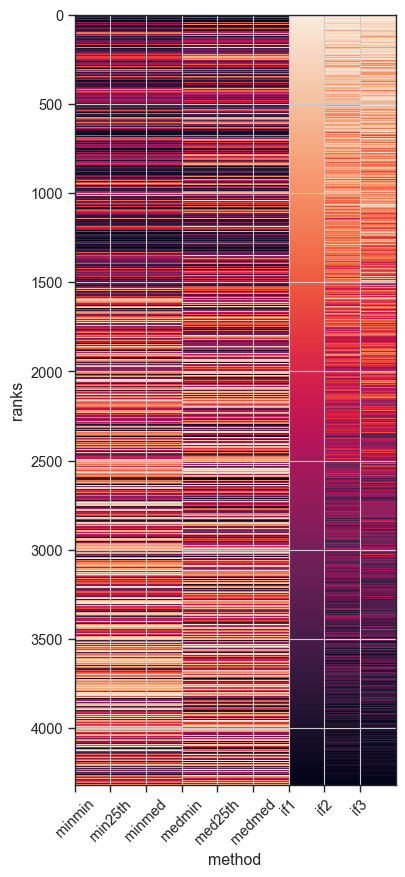

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(
    dist_aggregates_ranks.sort_values(by="if1", ascending=False), interpolation="none"
)
ax.set_aspect(0.005)
ax.set_xticks(np.arange(-0.5, 8.5), labels=dist_aggregates_ranks.columns, rotation=45)
ax.set_ylabel("ranks")
ax.set_xlabel("method")
ax.grid("off")

In [41]:
dist_aggregates[dist_aggregates["minmin"]==0].index

Index([], dtype='int64', name='snid')

In [42]:
# add epsilons to zeros
dist_aggregates.loc[dist_aggregates[dist_aggregates["minmin"]==0].index,["minmin"]] += np.finfo(np.float32).eps

In [43]:
dist_aggregates["minmin"].min()

0.00016490613679009947

In [44]:
dist_aggregates.min()

minmin     0.000165
min25th    0.000169
minmed     0.000174
medmin     0.011095
med25th    0.011363
medmed     0.011458
if1        -0.08831
if2       -0.083483
if3       -0.092617
class           AGN
dtype: object

/Users/sidchaini/miniconda3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


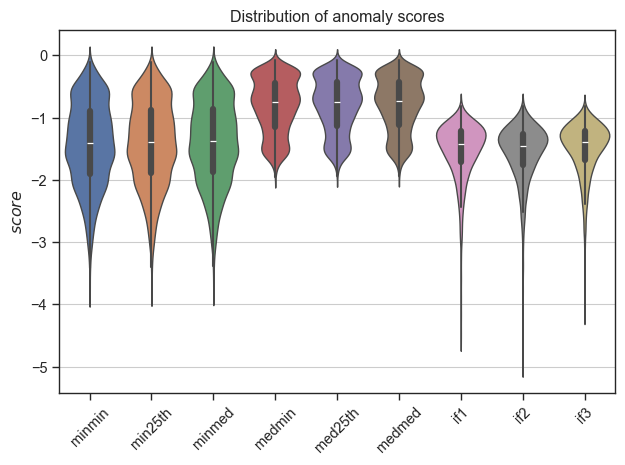

In [45]:
sns.violinplot(
    data=np.log10(dist_aggregates.drop("class",axis=1))
)
plt.title(f"Distribution of anomaly scores")
plt.ylabel(r"$score$")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
df = dist_aggregates

In [61]:
df.sort_values("if2",ascending=False).iloc[:20]

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3,class
snid,,,,,,,,,,
96837672,0.016655,0.017418,0.018180,0.068188,0.070287,0.072386,0.153602,0.155124,0.154811,CEP
34882116,0.005089,0.005162,0.005235,0.031737,0.032112,0.032487,0.140443,0.153602,0.150165,CEP
94602724,0.010289,0.010625,0.010962,0.027755,0.027931,0.028107,0.151189,0.152706,0.151189,CEP
92717442,0.016810,0.017320,0.017831,0.020444,0.020860,0.021277,0.142569,0.149095,0.140373,CEP
125103424,0.028378,0.028483,0.028587,0.101931,0.104670,0.107409,0.144949,0.147896,0.131143,CEP
83406315,0.029371,0.030125,0.030879,0.038483,0.040033,0.041583,0.128089,0.143122,0.129563,CEP
132356710,0.031175,0.032638,0.034101,0.038257,0.039716,0.041175,0.118630,0.141934,0.109123,CEP
59245585,0.127889,0.134325,0.140762,0.572195,0.575393,0.578591,0.123838,0.140197,0.134723,CEP
108559610,0.130094,0.132455,0.134816,0.354154,0.354661,0.355168,0.117724,0.138254,0.141980,CEP


In [57]:
df.sort_values("medmed",ascending=False).iloc[:20]

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3,class
snid,,,,,,,,,,
128394618,0.444243,0.449181,0.454118,0.857131,0.858496,0.859862,0.007151,0.040749,0.051594,Mdwarf-flare
106637001,0.632044,0.632539,0.633035,0.829542,0.830962,0.832381,-0.062375,-0.044941,-0.069050,DSCT
18804356,0.311507,0.317690,0.323872,0.828639,0.829689,0.830739,-0.029875,-0.032824,-0.041277,RRL
29729750,0.615692,0.618573,0.621454,0.811991,0.817905,0.823818,0.041603,0.015665,0.047704,CEP
70445893,0.772094,0.775128,0.778161,0.817486,0.818746,0.820005,-0.039714,-0.038053,-0.042484,RRL
156598736,0.519896,0.521693,0.523490,0.793398,0.799015,0.804633,0.043199,0.037622,0.060361,EB
142682678,0.590554,0.592458,0.594362,0.790761,0.797037,0.803313,0.014584,0.002027,0.012122,PISN-STELLA_HECORE
7983266,0.700631,0.701366,0.702100,0.791081,0.792374,0.793667,-0.074837,-0.062849,-0.067223,RRL
106963577,0.310913,0.311589,0.312265,0.769761,0.772281,0.774800,-0.006243,0.023049,0.005516,CEP


In [55]:
df.sort_values("med25th",ascending=False)

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3,class
snid,,,,,,,,,,
128394618,0.444243,0.449181,0.454118,0.857131,0.858496,0.859862,0.007151,0.040749,0.051594,Mdwarf-flare
106637001,0.632044,0.632539,0.633035,0.829542,0.830962,0.832381,-0.062375,-0.044941,-0.069050,DSCT
18804356,0.311507,0.317690,0.323872,0.828639,0.829689,0.830739,-0.029875,-0.032824,-0.041277,RRL
70445893,0.772094,0.775128,0.778161,0.817486,0.818746,0.820005,-0.039714,-0.038053,-0.042484,RRL
29729750,0.615692,0.618573,0.621454,0.811991,0.817905,0.823818,0.041603,0.015665,0.047704,CEP
...,...,...,...,...,...,...,...,...,...,...
69034398,0.009598,0.009761,0.009924,0.012617,0.013007,0.013398,0.062623,0.039116,0.064977,uLens-Binary
50015020,0.010477,0.010636,0.010796,0.011280,0.011824,0.012368,0.052397,0.034232,0.059511,EB
134561845,0.010531,0.010686,0.010841,0.011371,0.011823,0.012274,0.044501,0.048396,0.049144,CEP


In [56]:
df.sort_values("medmin",ascending=False)

,minmin,min25th,minmed,medmin,med25th,medmed,if1,if2,if3,class
snid,,,,,,,,,,
128394618,0.444243,0.449181,0.454118,0.857131,0.858496,0.859862,0.007151,0.040749,0.051594,Mdwarf-flare
106637001,0.632044,0.632539,0.633035,0.829542,0.830962,0.832381,-0.062375,-0.044941,-0.069050,DSCT
18804356,0.311507,0.317690,0.323872,0.828639,0.829689,0.830739,-0.029875,-0.032824,-0.041277,RRL
70445893,0.772094,0.775128,0.778161,0.817486,0.818746,0.820005,-0.039714,-0.038053,-0.042484,RRL
29729750,0.615692,0.618573,0.621454,0.811991,0.817905,0.823818,0.041603,0.015665,0.047704,CEP
...,...,...,...,...,...,...,...,...,...,...
69034398,0.009598,0.009761,0.009924,0.012617,0.013007,0.013398,0.062623,0.039116,0.064977,uLens-Binary
134561845,0.010531,0.010686,0.010841,0.011371,0.011823,0.012274,0.044501,0.048396,0.049144,CEP
50015020,0.010477,0.010636,0.010796,0.011280,0.011824,0.012368,0.052397,0.034232,0.059511,EB


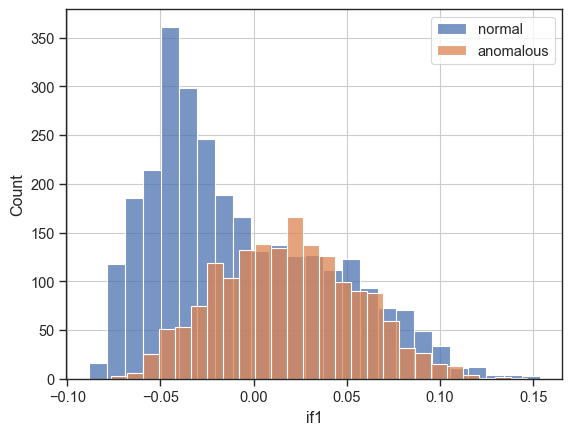

In [54]:
sns.histplot(df[df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)]["if1"], label="normal")

sns.histplot(df[~df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)]["if1"],label="anomalous")

plt.legend()
plt.show()

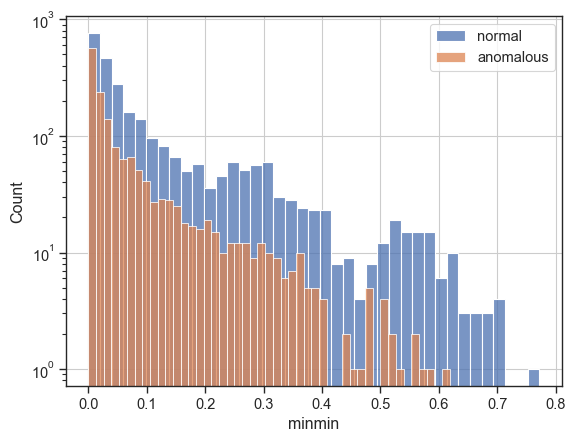

In [102]:
sns.histplot(df[df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)]["minmin"], label="normal")

sns.histplot(df[~df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)]["minmin"],label="anomalous")
plt.yscale("log")
plt.legend()
plt.show()

In [56]:
anom_classes = ['SNIa-91bg', 'SNII-Templates', 'dwarf-nova', 'Mdwarf-flare',
       'uLens-Single-GenLens', 'CART', 'SNIb+HostXT_V19',
       'uLens-Single_PyLIMA', 'SNIIn-MOSFIT', 'uLens-Binary', 'ILOT',
       'SNIcBL+HostXT_V19', 'SNIIn+HostXT_V19', 'EB',
       'PISN-STELLA_HECORE', 'SNIc-Templates', 'PISN-STELLA_HYDROGENIC',
       'PISN-MOSFIT', 'SNIb-Templates', 
       'SNII+HostXT_V19', 'SNIax', 'TDE', 'SLSN-I_no_host', 'SLSN-I+host',
       'SNIa-SALT3', 'SNIc+HostXT_V19', 'KN_K17', 'SL-SN1a', 'KN_B19',
       'SL-SNIb', 'SNIIb+HostXT_V19', 'SNII-NMF', 'SL-SNII', 'AGN', 'RRL',
       'SL-SNIc'], dtype=object)


array(['CEP', 'SNIa-91bg', 'SNII-Templates', 'dwarf-nova', 'Mdwarf-flare',
       'uLens-Single-GenLens', 'CART', 'SNIb+HostXT_V19',
       'uLens-Single_PyLIMA', 'SNIIn-MOSFIT', 'uLens-Binary', 'ILOT',
       'SNIcBL+HostXT_V19', 'SNIIn+HostXT_V19', 'EB',
       'PISN-STELLA_HECORE', 'SNIc-Templates', 'PISN-STELLA_HYDROGENIC',
       'PISN-MOSFIT', 'SNIb-Templates', 'DSCT', 'Cepheid',
       'SNII+HostXT_V19', 'SNIax', 'TDE', 'SLSN-I_no_host', 'SLSN-I+host',
       'SNIa-SALT3', 'SNIc+HostXT_V19', 'KN_K17', 'SL-SN1a', 'KN_B19',
       'SL-SNIb', 'SNIIb+HostXT_V19', 'SNII-NMF', 'SL-SNII', 'AGN', 'RRL',
       'd-Sct', 'SL-SNIc'], dtype=object)

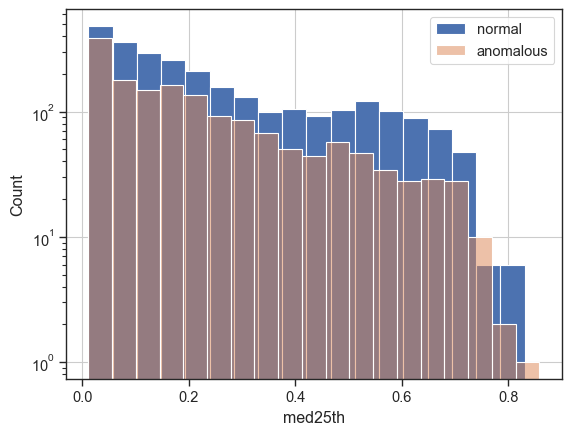

In [79]:
method = "med25th"

sns.histplot(df[df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)][method], label="normal", alpha=1)

sns.histplot(df[~df["class"].isin(["CEP",
"DSCT",
"EB",
"RRL",]
)][method],label="anomalous", alpha=0.5)

plt.yscale("log")
plt.legend()
plt.show()

In [84]:
normal_classes = ["CEP", "DSCT", "EB", "RRL"]
df['status'] = df['class'].apply(lambda x: 'normal' if x in normal_classes else 'anomalous')

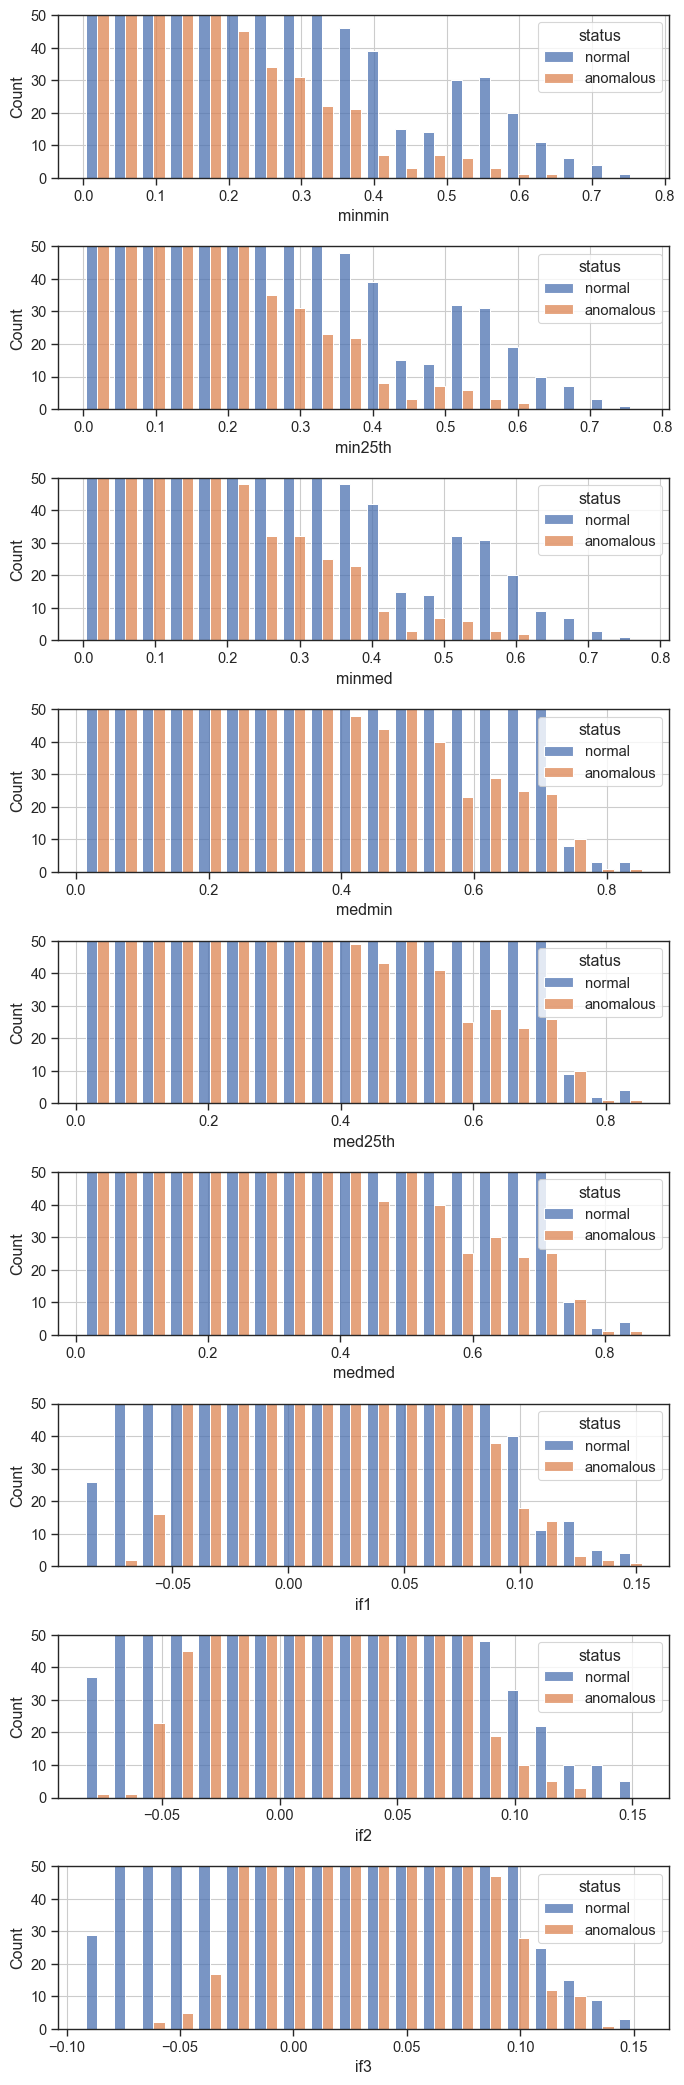

In [114]:
fig, axs = plt.subplots(9,1, figsize=(7,21))
axs = axs.ravel()
all_methods=["minmin", "min25th", "minmed", "medmin", "med25th", "medmed", "if1", "if2", "if3"]
for i, method in enumerate(all_methods):
    sns.histplot(data=df, x=method, hue='status', multiple="dodge", shrink=0.8, ax=axs[i],bins=20)
    # axs[i].set_yscale("log")
    axs[i].set_ylim([0,50])
plt.tight_layout()
plt.show()

In [116]:
df.to_csv("alldistanceifvals.csv",index=True)